# Unsupervised Image clustering

We will be doing that by encoding the images through a trained convolutional network, and then apply a clustering algorithm to the encoded features. We can then check the clusters and see if it worked!

### Let's import the libraries we'll need -  
Keras is using a TensorFlow backend in our case here.

In [1]:
% matplotlib inline

import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [3]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import sys 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import numpy as np
import os
import sys
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "C:\\Data_Science\\Data_science\\CAPP\\"
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
DIR = "C:\\Data_Science\\Data_science\\CAPP\\data\\natural_images\\combined\\"
sz=224

## Dataset information

The natural images are in directories with the following format:

Inside the DIR path, we have 3 sub folders containing images for 'airplane', 'car' and 'motorbike' respectively.

Examples:

We will use this information to list the category of natural image (airplane, car or motorbike) available and count the number of images available for each.

In [6]:
# directory where images are stored
#DIR = "./animal_images"
DIR = "C:\\Data_Science\\Data_science\\CAPP\\data\\natural_images\\combined\\"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    image_characters = ['A', 'C','M']
    
    # dictionary where we will store the stats
    stats = []
    
    for images in image_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, images)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": images,
                           "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [7]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
A,airplane,727
C,car,968
M,motorbike,788


## Loading the images
Now we create a function that loads all images in a directory for a given array of codes in one array and creates the corresponding label array for them.
Loaded images are resized to 224 x 224 before storing them in our array since this is the size preferred by VGG19 which we will be using later.

In [8]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

Now we chose our codes for the category of natural image that we want and load the images and labels.
We will choose 3 codes for airplane, car and motorbike respectively. 

In [9]:
codes = ['A', 'C','M']
images, labels = load_images(codes)

In [10]:

def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

### Let's have a look at the categories we loaded! 

The photos will not be in their original aspect ratio since we've resized them to fit what VGG needs

2 random images for code A


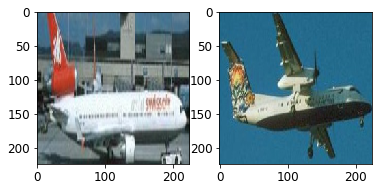

2 random images for code C


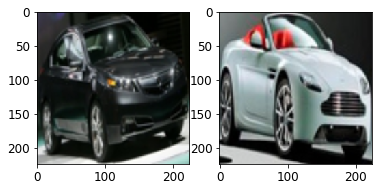

2 random images for code M


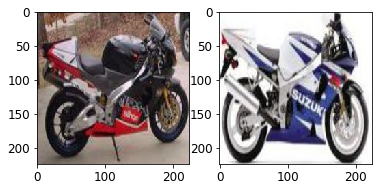

In [11]:
show_random_images(images, labels)

## Normalise...
We now convert the images and labels to NumPy arrays to make processing them easier. We then normaise the images before passing them on to VGG19

In [12]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [13]:
images, labels = normalise_images(images, labels)

We'll be using the train_test_split function from sklearn which will also shuffle the data around for us, since it's currently in order.

In [14]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0, random_state=728)
    
    return X_train, y_train

In [15]:
X_train, y_train = shuffle_data(images, labels)

## Load pre-trained covnet models
VGG16, VG19, ResNet50
We'll now load up the keras models with the imagenet weights. We'll remove the top dense layers, since we won't need to classify things here, and we just want these encoded features from the images.

In [16]:
# # Load the models with ImageNet weights

# vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

# vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

# resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [17]:
# vgg16_model.save('vgg16_model.h5')
# vgg19_model.save('vgg19_model.h5')
# resnet50_model.save('resnet50_model.h5')

In [18]:
from  keras.models import load_model

In [19]:
vgg16_model = load_model('vgg16_model.h5')
vgg19_model = load_model('vgg19_model.h5')
resnet50_model = load_model('resnet50_model.h5')

C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\Divyojyoti Sinha\Anaconda3\lib\site-packages\keras\engine\saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Flattening the output array

The covnet models will give us 3D vectors that represent the image. We need to flatten these for the clustering algorithms to start working with them.

In [20]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [21]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


The above cell shows us the number of features each covnet gives to a single image. When we compare these to the original size of the image 224 x 224 x 3 = 150,528 pixels/features, we can see that this is a large reduction in what the clustering algorithms will have to work with.
Hopefully these reduces number of feature are represent more meaningful features in the image structure.

## PCA
While k-means clustering has coped with these numbers, Gaussian Mixture Modelling has not and the computer consistently ran out of memory and struggled to produce results.
We therefore look to PCA for dimensionality reduction, so that our clustering algorithms can cope.

In [22]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [23]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)

In [24]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

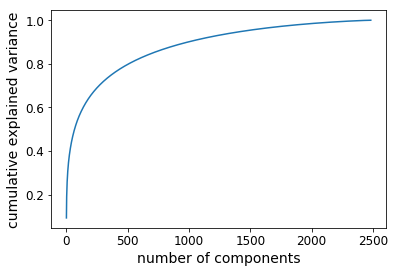

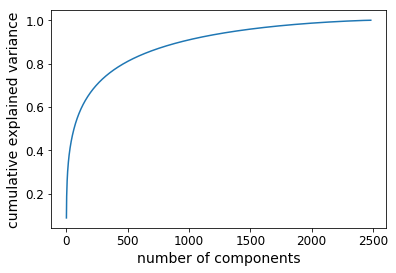

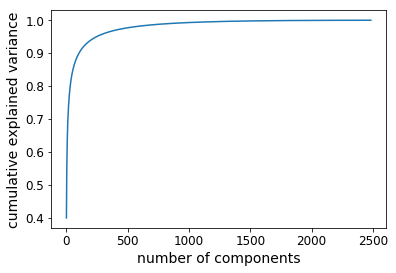

In [25]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

Looking at the graphs above, we can see that PCA can explain almost all the variance in as many dimensions as there are samples.
It is also interesting to note the difference in shape between the VGG graphs and the ResNet one. This is probably due to the fact that ResNet only had 2048 dimensions to start with, while VGGs had 25,088.

In [26]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

## Clustering

Cluster time......
Let's write a couple of functions that would create and fit KMeans and Gaussian Mixture models. While it can make sense to combine them in one function that returns both, I've seperated them so we can execute them seperately and make some observations without overloading the PC.

In [27]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [28]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [29]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 39.23600125312805 seconds

VGG19
Training took 5.558264970779419 seconds

ResNet50
Training took 4.413320302963257 seconds


In [30]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)

GMM (PCA): 

VGG16
Training took 10.231150388717651 seconds

VGG19
Training took 8.467363357543945 seconds

ResNet50
Training took 8.278722763061523 seconds


**Attempts to run the Gaussian Mixtue Model on the outputs without PCA always give an out of memory error. We were therefore unable to test these and conclude that they are impractical to use.**


In [31]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# # KMeans with CovNet outputs
# k_vgg16_pred = K_vgg16.predict(vgg16_output)
# k_vgg19_pred = K_vgg19.predict(vgg19_output)
# k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

 The clustering algorith does not detect which images are airplane, car or motorbike, it only groups images that look alike together and assigns them a number arbitrarily.
We now need to count how many of each label are in each cluster, this way we can take a look and if sufficient operation has happened we can quicly see which cluster is which label. So let's write a function that does that.

In [32]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [33]:
# Cluster counting for VGG16 Means
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

## Model 1

In [34]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2
A,0,2,725
C,0,966,2
M,784,2,2


## Model 2

In [35]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1,2
A,721,2,4
C,2,966,0
M,0,2,786


In [36]:
print("KMeans ResNet50 (PCA): ")
resnet_cluster_count_pca

KMeans ResNet50 (PCA): 


,0,1,2
A,700,27,0
C,870,98,0
M,95,409,284


We can see now that the KMeans ResNet50 (PCA) Model did not give a meaningful result. There are no clear dominant code for each cluster

## Model 3

In [37]:
print("GMM VGG16 (PCA): ")
g_vgg16_cluster_count_pca

GMM VGG16 (PCA): 


,0,1,2
A,2,725,0
C,966,2,0
M,2,2,784


In [38]:

print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1,2
A,0,727,0
C,441,3,524
M,0,788,0


We can see now that the GMM VGG19 (PCA) Model did not give a meaningful result. There are no clear dominant code for each cluster

In [39]:
print("GMM RESNET50 (PCA): ")
g_resnet50_cluster_count_pca

GMM RESNET50 (PCA): 


,0,1,2
A,30,0,697
C,107,0,861
M,399,298,91


We can see again, that models which took ResNet50 representations could not produce meaningful clusters. We will therefore stop pursuing them.
The models that made it through are:

- KMeans VGG16 PCA
- KMeans VGG19 PCA
- GMM VGG16 (PCA)

Let's calculate some scores and see which one performs best.

### Cluster - Label assignment
In this part, we will manually look at the cluster count and give a best guess as to which cluster corresonds to which label. While normally each cluster will mostly consist of one label, it is not necessary the case if the clustering algorithm fails to seperate the images. It is therefore better to take stock here, and make sure that we are on the right path.

In [40]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code_pca = ["M", "C", "A"]

vgg19_cluster_code_pca = ["A", "C", "M"]
g_vgg16_cluster_code_pca = ["C", "A", "M"]

## Replace the predicted clusters with their labels

In [41]:
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
g_vgg16_pred_codes_pca = [g_vgg16_cluster_code_pca[x] for x in g_vgg16_pred_pca]

## Metrics

Now that we have two arrays, one with the predicted labels and one with the true labels, we just computed the F1 score.

In [42]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))

print("\nKMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))

print("\nGMM VGG16 (PCA): ", print_scores(y_train, g_vgg16_pred_codes_pca))

KMeans VGG16 (PCA) 
	F1 Score: 0.99674621   |   Accuracy: 0.99674621

KMeans VGG19 (PCA):  
	F1 Score: 0.99586150   |   Accuracy: 0.99586150

GMM VGG16 (PCA):  
	F1 Score: 0.99674621   |   Accuracy: 0.99674621
